# Project Solution Lab 2: 

# Problem: Recommend Movies or Shows to Users

Modified from:
- [Implementing a Recommender System with SageMaker, MXNet, and Gluon](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/gluon_recommender_system/gluon_recommender_system.ipynb)
- [An Introduction to Factorization Machines with MNIST](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/factorization_machines_mnist/factorization_machines_mnist.ipynb)
- [Extending Amazon SageMaker Factorization Machines Algorithm to Predict Top X Recommendations](https://aws.amazon.com/blogs/machine-learning/extending-amazon-sagemaker-factorization-machines-algorithm-to-predict-top-x-recommendations/)

## Introduction to business scenario

You work for a startup that focuses on delivering on-demand video streaming services to users. The company wants to introduce movie/show recommendations for their users based on their viewing history.

You are tasked with solving part of this problem by leveraging machine learning to create a recommendation engine to be used on the user website. You are given access to the dataset of historical user preferences and the movies they watched. You can use this to train a machine learning model to recommend movies/shows to watch.

## About this dataset  
The Amazon Customer Reviews Dataset is a collection of reviews on different products from the Amazon.com marketplace from 1995 until 2015. Customer reviews are one of the most important data types at Amazon. Collecting and showing reviews has been part of the Amazon culture since the beginning of the company and is arguably one important source of innovation. For more details on this dataset, see [Amazon Customer Reviews Dataset](https://s3.amazonaws.com/amazon-reviews-pds/readme.html).

This exercise focuses on reviews of videos. The videos dataset contains 1- to 5-star ratings from over 2M Amazon customers on 160K digital videos.

### Features

**Data columns**

- `marketplace`: Two-letter country code (in this case, all "US")
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author
- `review_id`: Unique ID for the review
- `product_id`: Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN\> links to the product's detail page.
- `product_parent`: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product
- `product_category`: Broad product category that can be used to group reviews (in this case, digital videos)
- `star_rating`: Product's rating (1 to 5 stars)
- `helpful_votes`: Number of helpful votes for the review
- `total_votes`: Number of total votes the review received
- `vine`: Was the review written as part of the Vine program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: Title of the review itself
- `review_body`: Text of the review
- `review_date`: Date the review was written 

**Data format**
- Tab `\t` separated text file, without quote or escape characters
- First line in each file is header; 1 line corresponds to 1 record

### Dataset attributions

Website: https://s3.amazonaws.com/amazon-reviews-pds/readme.html

This dataset is being provided to you by permission of Amazon and is subject to the terms of the AWS Digital Training Service Agreement (available at https://aws.amazon.com/training/digital-training-agreement). You are expressly prohibited from copying, modifying, selling, exporting, or using this dataset in any way other than for the purpose of completing this lab.

## Brainstorming and designing a question...

...That you can answer with machine learning. 

The first step in most projects is to think about the question you want to ask, how the data available supports this question, and which tool (in this case, machine learning model) you are going to use to answer the question. This is an important step because it helps narrow the scope of exploration and gives clarity on the features that you are going to use. 

Take a moment to write your thoughts regarding the dataset in the cell below. What are the things you can predict with machine learning? Why may that be relevant from a business/client perspective? Explain why you consider these thoughts important.

In [1]:
# Write your thoughts here

There might be several ideas about what to do with the data, but for now we are all going to work on recommending a video to a particular user.

## Recommendation and factorization machines

In many ways, recommender systems were a catalyst for the current popularity of machine learning. One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature. The million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

Recommender systems can utilize a multitude of data sources and machine learning algorithms. Most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework. However, the core component is almost always a model that predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users. The minimal required dataset for this is a history of user item ratings (which we have).

The method that you'll use is a factorization machine. A factorization machine is a general-purpose supervised learning algorithm that you can use for both classification and regression tasks. It is an extension of a linear model and is designed to parsimoniously (simply) capture interactions between features in high-dimensional sparse datasets. This makes it a good candidate to handle data patterns with features such as click prediction and item recommendation.

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents.

#### <span style="color: blue;">Project presentation: Include a summary of these details in your project presentations.</span>

### Read through a business scenario and:

### 1. Determine if and why ML is an appropriate solution to deploy.
\# Write your answer here

### 2. Formulate the business problem, success metrics, and desired ML output.
\# Write your answer here

### 3. Identify the type of ML problem you’re dealing with.
\# Write your answer here

### 4. Analyze the appropriateness of the data you’re working with.
\# Write your answer here


### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance. 

Start by specifying:
- The Amazon Simple Storage Service (Amazon S3) bucket and prefix(?) that you want to use for training and model data. This should be within the same Region as the Notebook Instance, training, and hosting.
- The AWS Identity and Access Management (IAM) role [Amazon Resource Name (ARN)](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) used to give training and hosting access to your data. See the documentation for how to create these.

**Note:** If more than one role is required for notebook instances, training, and/or hosting, replace the `get_execution_role()` call with the appropriate full IAM role ARN string(s).

Replace **`<LabBucketName>`** with the resource name that was provided with your lab account.

In [2]:
# Change the bucket and prefix according to your information
#bucket = '<LabBucketName>'
bucket = 'ml-pipeline-bucket'
prefix = 'sagemaker-fm' 

import sagemaker
role = sagemaker.get_execution_role()

Now, load some Python libraries you'll need for the remainder of this example notebook.

In [3]:
import os, subprocess
import warnings
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Add this to display all the outputs in the cell and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and other similar questions in your project presentations.</span>

Start by bringing in the dataset from an Amazon S3 public bucket to this notebook environment.

In [4]:
# Check whether the file is already in the desired path or if it needs to be downloaded

base_path = '/home/ec2-user/SageMaker/project/data/AmazonReviews'
file_path = '/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['aws', 's3', 'cp', 's3://amazon-reviews-pds/tsv' + file_path, base_path])
else:
    print('File already downloaded!')

CompletedProcess(args=['mkdir', '-p', '/home/ec2-user/SageMaker/project/data/AmazonReviews'], returncode=0)

CompletedProcess(args=['aws', 's3', 'cp', 's3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Download_v1_00.tsv.gz', '/home/ec2-user/SageMaker/project/data/AmazonReviews'], returncode=0)

### Reading the dataset

Read the data into a Pandas dataframe so that you can know what you are dealing with.

**Note:** You'll set `error_bad_lines=False` when reading the file in, because there appear to be a very small number of records that would create a problem otherwise.

**Hint:** You can use the built-in Python `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)). You can use the file path directly with Pandas `read_csv` with `delimiter='\t'`.

For example: `pd.read_csv('filename.tar.gz', delimiter = '\t', error_bad_lines=False)`

In [5]:
df = pd.read_csv(base_path + file_path, 
                 delimiter='\t',
                 error_bad_lines=False)

b'Skipping line 92523: expected 15 fields, saw 22\n'
b'Skipping line 343254: expected 15 fields, saw 22\n'
b'Skipping line 524626: expected 15 fields, saw 22\n'
b'Skipping line 623024: expected 15 fields, saw 22\n'
b'Skipping line 977412: expected 15 fields, saw 22\n'
b'Skipping line 1496867: expected 15 fields, saw 22\n'
b'Skipping line 1711638: expected 15 fields, saw 22\n'
b'Skipping line 1787213: expected 15 fields, saw 22\n'
b'Skipping line 2395306: expected 15 fields, saw 22\n'
b'Skipping line 2527690: expected 15 fields, saw 22\n'


Print the first few rows of your dataset.

**Hint**: Use the `pandas.head(<number>)` function to print the rows.

In [6]:
df.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31


Now what is the information contained in all the columns?

### Anatomy of the dataset

Get a little more comfortable with the data and see what features are at hand.

- `marketplace`: Two-letter country code (in this case, all "US")
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author
- `review_id`: Unique ID for the review
- `product_id`: Amazon Standard Identification Number (ASIN). http://www.amazon.com/dp/<ASIN\> links to the product's detail page.
- `product_parent`: The parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product
- `product_category`: Broad product category that can be used to group reviews (in this case, digital videos)
- `star_rating`: Product's rating (1 to 5 stars)
- `helpful_votes`: Number of helpful votes for the review
- `total_votes`: Number of total votes the review received
- `vine`: Was the review written as part of the Vine program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: Title of the review itself
- `review_body`: Text of the review
- `review_date`: Date the review was written

### Analyzing and processing the dataset

#### Exploring the data

**Question:** How many rows and columns do you have in the dataset?

Check the size of the dataset.  

**Hint**: Use the `<dataframe>.shape` function to check the size of your dataframe

In [7]:
df.shape

(3998345, 15)

Answer: (3998345,15)

**Question:** Which columns contain null values, and how many null values do they contain?

Print a summary of the dataset.

**Hint**: Use `<dataframe>.info` function using the keyword arguments `null_counts = True`

In [8]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3998345 entries, 0 to 3998344
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   marketplace        3998345 non-null  object
 1   customer_id        3998345 non-null  int64 
 2   review_id          3998345 non-null  object
 3   product_id         3998345 non-null  object
 4   product_parent     3998345 non-null  int64 
 5   product_title      3998345 non-null  object
 6   product_category   3998345 non-null  object
 7   star_rating        3998345 non-null  int64 
 8   helpful_votes      3998345 non-null  int64 
 9   total_votes        3998345 non-null  int64 
 10  vine               3998345 non-null  object
 11  verified_purchase  3998345 non-null  object
 12  review_headline    3998320 non-null  object
 13  review_body        3998267 non-null  object
 14  review_date        3998207 non-null  object
dtypes: int64(5), object(10)
memory usage: 457.6+ MB


**Answer:** Review headline: 25, Review_body: 78, Review_date: 138

**Question:** Are there any duplicate rows? If yes, how many are there?

**Hint**: Filter the dataframe using `dataframe.duplicated()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html#pandas.DataFrame.duplicated)) and check the length of the new dataframe.

In [9]:
duplicates = df[df.duplicated()]

len(duplicates)

0

**Answer:** There are no duplicated rows.

### Data preprocessing

Now it's time to decide what features you are going to use and how you are going to prepare them for your model. For this example, limit yourself to `customer_id`, `product_id`, `product_title`, and `star_rating`. Including additional features in the recommendation system could be beneficial but would require substantial processing (particularly the text data), which would be beyond the scope of this notebook.

Reduce this dataset and only use the columns mentioned.

**Hint:** Select multiple columns as a dataframe by passing the columns as a list. For example: `df[['column_name 1', 'column_name 2']]`

In [10]:
df_reduced = df[['customer_id', 'product_id', 'star_rating', 'product_title']]

Check if you have duplicates after reducing the dataset. 

In [11]:
duplicates = df_reduced[df_reduced.duplicated()]

len(duplicates)

131

**Answer**: 131

**Question:** Why do you have duplicates in your dataset now? What changed after you reduced the dataset? Review the first 20 lines of the duplicates.

**Hint**: Use the `pandas.head(<number>)` function to print the rows.

In [12]:
duplicates.head(20)

,customer_id,product_id,star_rating,product_title
565194,41454255,B00Y2UYRFS,1,unseen 2
594322,17570065,B00R3EEO2G,2,The Maze Runner
611264,15703996,B00I3MQNWG,5,Bosch Season 1
612471,28456429,B008Y6W7J4,5,Rabbit Hole
613791,52388381,B00YORA25I,5,"McFarland, USA (Theatrical)"
685156,31828958,B00TT53YSW,5,"Bates Motel, Season 3"
1204110,19462,B00QWUL4AW,5,Exodus: Gods and Kings
1564816,24892653,B00L2GPYKW,5,The Escape Artist Season 1
1601662,44513234,B00NY4UIKG,5,The Equalizer
1616429,43345475,B00P5968FC,3,The Babadook


**Hint:** Take a look at the first two elements in the duplicates dataframe, and query the original dataframe df to see what the data looks like. You can use the `query` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html)).

For example:

```
df_eg = pd.DataFrame({
            'A': [1,2,3,4],
            'B': [
        })
df_eg.query('A > 1 & B > 0')
```

In [13]:
df.query("customer_id == 17570065 & product_id == 'B00R3EEO2G'")

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
588857,US,17570065,RZ0MXSMTR2WQP,B00R3EEO2G,226574237,The Maze Runner,Digital_Video_Download,2,0,0,N,Y,Two Stars,Simply doesn't engage the audience.,2015-06-08
594322,US,17570065,R26IBV6N1BV1VN,B00R3EEO2G,226574237,The Maze Runner,Digital_Video_Download,2,0,0,N,Y,Two Stars,Simply doesn't engage the audience.,2015-06-08


**Answer:** The dataset has duplicates because there are products with the same information but different `review_id` or `product_id`.

Before continuing, remove the duplicate rows.

**Hint**: Use the `~` operator to select all the rows that aren't duplicated. For example:
    
```
df_eg = pd.DataFrame({
            'A': [1,2,3,4],
            'B': [2,0,5,2]
        })
df_eg[~(df_eg['B'] > 0)]
```

In [14]:
df_reduced = df_reduced[~df_reduced.duplicated()]

### Visualize some of the rows in the dataset
If you haven't done so in the above, you can use the space below to further visualize some of your data. Look specifically at the distribution of features like `star_rating`, `customer_id`, and `product_id`.

**Specific questions to consider**

1. After looking at the distributions of features, to what extent might those features help your model? Is there anything you can deduce from those distributions that might be helpful in better understanding your data? 

2. Should you use all the data? What features should you use?

3. What month has the highest count of user ratings?

Use the cells below to visualize your data and answer these and other questions that might be of interest to you. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and similar questions in your project presentations.</span>

Use `sns.barplot` ([documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html)) to plot the `star_rating` density and distribution.

,index,star_rating
0,5,2410533
1,4,756423
2,3,345891
3,1,289731
4,2,195767


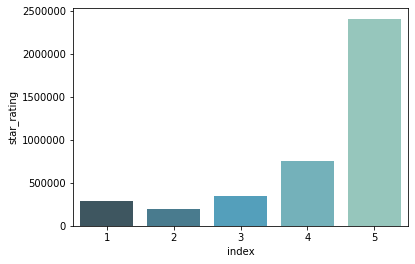

In [15]:
# Count the number of reviews with a specific rating
df['star_rating'].value_counts().reset_index()
sns.barplot(
    x='index', 
    y='star_rating', 
    data=_,  # The underscore symbol in Python is used to store the output of the last operation
    palette='GnBu_d'
)

**Question:** What month contains the highest count of user ratings?

**Hint**:  
1. Use `pd.to_datetime` to convert the `review_date` column to a datetime column.  
2. Use the month from the `review_date` column. You can access it for a datetime column using `<column_name>.dt.month`.
3. Use the `groupby` function using `idxmax`.


,review_date,star_rating
0,1.0,309083
1,2.0,369059
2,3.0,432084
3,4.0,363611
4,5.0,339285
5,6.0,328114
6,7.0,417844
7,8.0,464912
8,9.0,206453
9,10.0,218583


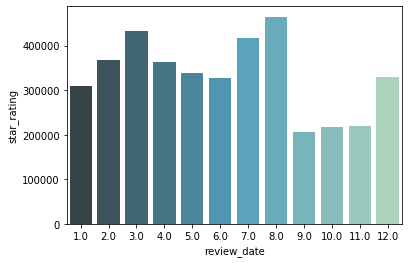

In [16]:
# Convert the review date to a datetime type and count the number of ratings by month
df['review_date'] = pd.to_datetime(df.review_date)
df.groupby(df.review_date.dt.month).star_rating.count().reset_index()
sns.barplot(x='review_date', y='star_rating', data=_, palette='GnBu_d')

In [17]:
max_month = df.groupby(df.review_date.dt.month).star_rating.count().idxmax()
print(f'The month with the most reviews is: {max_month}')

The month with the most reviews is: 8.0


**Bonus question (optional):** Which years have the most and least reviews?

In [1]:
df.groupby(df.review_date.dt.year).star_rating.count().reset_index()
fig = plt.gcf()
fig.set_size_inches(10, 5)
sns.barplot(x='review_date', y='star_rating', data=_, palette='GnBu_d')

NameError: name 'df' is not defined

**Answer:** The years with the least amount of data are 2000 and 2001, with only 1 review. The year with the highest number of reviews is 2015.

### Cleaning data

**Question**: How heterogeneous are the number of reviews per customer and reviews per video? Use quantiles to find out.

**Hint**: Use `<dataframe>['columns_name'].value_counts()` for the customers and products dataframe, and use `<dataframe>.quantile(<list>)` to find the relationship.

In [19]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 
             0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 
             0.999, 1]
print('customers\n', customers.quantile(quantiles))
print('products\n', products.quantile(quantiles))

customers
 0.000       1.0
0.010       1.0
0.020       1.0
0.030       1.0
0.040       1.0
0.050       1.0
0.100       1.0
0.250       1.0
0.500       1.0
0.750       2.0
0.900       4.0
0.950       5.0
0.960       6.0
0.970       7.0
0.980       9.0
0.990      13.0
0.995      18.0
0.999      37.0
1.000    2704.0
Name: customer_id, dtype: float64
products
 0.000        1.000
0.010        1.000
0.020        1.000
0.030        1.000
0.040        1.000
0.050        1.000
0.100        1.000
0.250        1.000
0.500        3.000
0.750        9.000
0.900       31.000
0.950       73.000
0.960       95.000
0.970      130.000
0.980      199.000
0.990      386.670
0.995      699.000
0.999     1993.901
1.000    32790.000
Name: product_id, dtype: float64


**Answer:** Only about 5% of customers have rated 5 or more videos, and only 25% of videos have been rated by 9+ customers.

Filter out this long tail. Select the customers that have rated 18 or more videos and the products that have more than 95 reviews.

In [20]:
customers1 = customers[customers >= 18]
products1 = products[products >= 95]

reduced_df = (
    df_reduced.merge(pd.DataFrame({'customer_id': customers1.index}))
              .merge(pd.DataFrame({'product_id': products1.index}))
)

**Question:** What is the shape of `customers1`, `products1`, and the new dataframe reduced_df?

**Note**: Use f-strings for this:

```
x= 3
print(f'X = {x}')
```

In [21]:
print(f'Number of users is {customers1.shape[0]} and number of items is {products1.shape[0]}.')
print(f'Length of reduced df is {reduced_df.shape[0]}.')

Number of users is 10538 and number of items is 6683.
Length of reduced df is 173500.


Print the first 5 columns of the dataframe.

In [22]:
reduced_df.head()

,customer_id,product_id,star_rating,product_title
0,11763902,B00PSLQYWE,4,Downton Abbey Season 5
1,1411480,B00PSLQYWE,5,Downton Abbey Season 5
2,35303629,B00PSLQYWE,5,Downton Abbey Season 5
3,21285980,B00PSLQYWE,5,Downton Abbey Season 5
4,29260449,B00PSLQYWE,5,Downton Abbey Season 5


**Question:** Does `reduced_df` maintain the same ratio of ratings?

,index,star_rating
0,5,86200
1,4,42668
2,3,24470
3,2,10803
4,1,9359


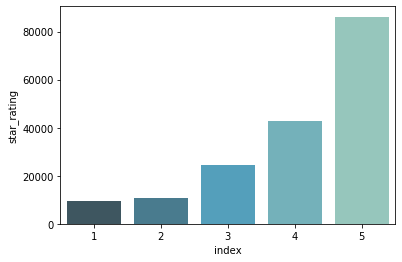

In [23]:
reduced_df['star_rating'].value_counts().reset_index()
sns.barplot(x='index', y='star_rating', data=_, palette='GnBu_d')

**Answer:** The number of reviews with a 1-star rating decreased in proportion to 2-star ratings. That was not the case with the original data.

Now, recreate the customer and product distributions of count per customer and product.  

**Hint**: Use the `value_counts()` function on the `customer_id` and `product_id` columns.

Text(0.5, 0.98, 'Distribution of counts per customer and product')

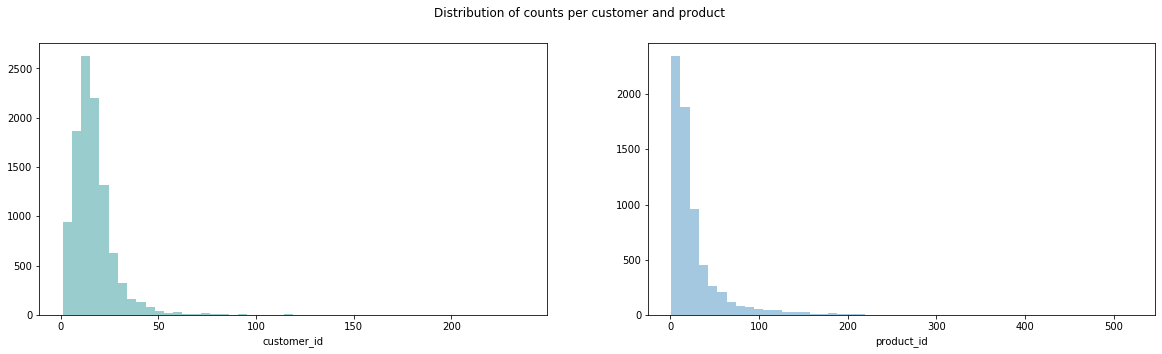

In [24]:
customers = reduced_df['customer_id'].value_counts()
products = reduced_df['product_id'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Distribution of counts per customer and product')
sns.distplot(customers, kde=False, ax=axs[0], color='teal')
sns.distplot(products, kde=False, ax=axs[1])

Next, number each user and item, giving them their own sequential index. This will allow you to hold the information in a sparse format where the sequential indices indicate the row and column in the ratings matrix.

To create the `customer_index` and `product_index`, create a new dataframe with `customer_id` as the index value and a sequential counter/values for the user and item number. Once you are finished creating both indexes, use the Pandas `merge` function to merge `customer_index` with `product_index`.

**Hint**: Use the `shape` function to generate the total number of customers and products. Use `np.arange` to generate a list of numbers from 0 to the number of customers and products.

In [25]:
customer_index = pd.DataFrame({'customer_id': customers.index, 
                               'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(customer_index).merge(product_index)
reduced_df.head()

,customer_id,product_id,star_rating,product_title,user,item
0,11763902,B00PSLQYWE,4,Downton Abbey Season 5,3065,102
1,1411480,B00PSLQYWE,5,Downton Abbey Season 5,130,102
2,35303629,B00PSLQYWE,5,Downton Abbey Season 5,4682,102
3,21285980,B00PSLQYWE,5,Downton Abbey Season 5,449,102
4,29260449,B00PSLQYWE,5,Downton Abbey Season 5,131,102


Sample answer:
<div class="output_subarea"><div>

<table class="dataframe" border="1">
  <thead>
    <tr style="text-align: right">
      <th></th>
      <th>customer_id</th>
      <th>product_id</th>
      <th>star_rating</th>
      <th>product_title</th>
      <th>user</th>
      <th>item</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>11763902</td>
      <td>B00PSLQYWE</td>
      <td>4</td>
      <td>Downton Abbey Season 5</td>
      <td>3065</td>
      <td>103</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1411480</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>130</td>
      <td>103</td>
    </tr>
    <tr>
      <th>2</th>
      <td>35303629</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>4683</td>
      <td>103</td>
    </tr>
    <tr>
      <th>3</th>
      <td>21285980</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>449</td>
      <td>103</td>
    </tr>
    <tr>
      <th>4</th>
      <td>29260449</td>
      <td>B00PSLQYWE</td>
      <td>5</td>
      <td>Downton Abbey Season 5</td>
      <td>131</td>
      <td>103</td>
    </tr>
  </tbody>
</table>
</div></div>